In [2]:
import pandas as pd
df= pd.read_csv('styles.csv')
df.dropna(inplace = True)
print(df.head())
classes = df['subCategory'].unique()
classes.sort()
dic_classes = {}
for i in range(len(classes)):
    dic_classes[classes[i]] = i
print(dic_classes)
dic ={}
for i in range(len(df)):
    dic[df.iloc[i]['id']+'.jpg'] = dic_classes[df.iloc[i]['subCategory']]


      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
{'Accessories': 0, 'Apparel Set': 1, 'Bags': 2, 'Bath and Body': 3, 'Beauty Accessories': 4, 'Belts': 5, 'Bottomwear': 6, 'Cuffli

In [3]:
classes

array(['Accessories', 'Apparel Set', 'Bags', 'Bath and Body',
       'Beauty Accessories', 'Belts', 'Bottomwear', 'Cufflinks', 'Dress',
       'Eyes', 'Eyewear', 'Flip Flops', 'Fragrance', 'Free Gifts',
       'Gloves', 'Hair', 'Headwear', 'Home Furnishing', 'Innerwear',
       'Jewellery', 'Lips', 'Loungewear and Nightwear', 'Makeup',
       'Mufflers', 'Nails', 'Perfumes', 'Sandal', 'Saree', 'Scarves',
       'Shoe Accessories', 'Shoes', 'Skin', 'Skin Care', 'Socks',
       'Sports Accessories', 'Sports Equipment', 'Stoles', 'Ties',
       'Topwear', 'Umbrellas', 'Vouchers', 'Wallets', 'Watches',
       'Water Bottle', 'Wristbands'], dtype=object)

In [4]:
dic_classes

{'Accessories': 0,
 'Apparel Set': 1,
 'Bags': 2,
 'Bath and Body': 3,
 'Beauty Accessories': 4,
 'Belts': 5,
 'Bottomwear': 6,
 'Cufflinks': 7,
 'Dress': 8,
 'Eyes': 9,
 'Eyewear': 10,
 'Flip Flops': 11,
 'Fragrance': 12,
 'Free Gifts': 13,
 'Gloves': 14,
 'Hair': 15,
 'Headwear': 16,
 'Home Furnishing': 17,
 'Innerwear': 18,
 'Jewellery': 19,
 'Lips': 20,
 'Loungewear and Nightwear': 21,
 'Makeup': 22,
 'Mufflers': 23,
 'Nails': 24,
 'Perfumes': 25,
 'Sandal': 26,
 'Saree': 27,
 'Scarves': 28,
 'Shoe Accessories': 29,
 'Shoes': 30,
 'Skin': 31,
 'Skin Care': 32,
 'Socks': 33,
 'Sports Accessories': 34,
 'Sports Equipment': 35,
 'Stoles': 36,
 'Ties': 37,
 'Topwear': 38,
 'Umbrellas': 39,
 'Vouchers': 40,
 'Wallets': 41,
 'Watches': 42,
 'Water Bottle': 43,
 'Wristbands': 44}

In [ ]:
''''import os
for label in classes: 
    os.mkdir('train_images/'+label)'''

In [5]:
'''from tqdm import tqdm_notebook
import shutil
for i in tqdm_notebook(range(len(df))):
    if os.path.exists('images/'+df.iloc[i]['id']+'.jpg'):
        shutil.copy('images/'+df.iloc[i]['id']+'.jpg','train_images/'+df.iloc[i]['subCategory'])'''

"from tqdm import tqdm_notebook\nimport shutil\nfor i in tqdm_notebook(range(len(df))):\n    if os.path.exists('images/'+df.iloc[i]['id']+'.jpg'):\n        shutil.copy('images/'+df.iloc[i]['id']+'.jpg','train_images/'+df.iloc[i]['subCategory'])"

In [50]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import pickle
from lshash import LSHash
from PIL import Image

In [7]:
from __future__ import print_function
from __future__ import division
import torch
torch.cuda.current_device()
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [8]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = len(classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [11]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

['Accessories' 'Apparel Set' 'Bags' 'Bath and Body' 'Beauty Accessories'
 'Belts' 'Bottomwear' 'Cufflinks' 'Dress' 'Eyes' 'Eyewear' 'Flip Flops'
 'Fragrance' 'Free Gifts' 'Gloves' 'Hair' 'Headwear' 'Home Furnishing'
 'Innerwear' 'Jewellery' 'Lips' 'Loungewear and Nightwear' 'Makeup'
 'Mufflers' 'Nails' 'Perfumes' 'Sandal' 'Saree' 'Scarves'
 'Shoe Accessories' 'Shoes' 'Skin' 'Skin Care' 'Socks'
 'Sports Accessories' 'Sports Equipment' 'Stoles' 'Ties' 'Topwear'
 'Umbrellas' 'Vouchers' 'Wallets' 'Watches' 'Water Bottle' 'Wristbands']
torch.Size([32, 3, 224, 224])


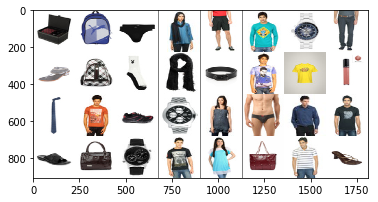

Accessories  Bags Innerwear Stoles Bottomwear Topwear Watches Bottomwear Shoes  Bags Socks Scarves Belts Topwear Topwear  Lips


In [13]:
transform = transforms.Compose(
    [transforms.Resize((224,224), interpolation=2),  transforms.RandomHorizontalFlip(), transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader =torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('train_images',transform=transform), batch_size=batch_size,
                                          shuffle=True, num_workers=2)

print(classes)
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    #val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        #for phase in ['train', 'val']:
        #    if phase == 'train':
        #        model.train()  # Set model to training mode
        #    else:
        #        model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in tqdm_notebook(dataloaders): #[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            #with torch.set_grad_enabled(phase == 'train'):
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            #   mode we calculate the loss by summing the final output and the auxiliary output
            #   but in testing we only consider the final output.
            if is_inception :#and phase == 'train':
                # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                outputs, aux_outputs = model(inputs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4*loss2
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward + optimize only if in training phase
            #if phase == 'train':
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

        # deep copy the model
        #if phase == 'val' and epoch_acc > best_acc:
         #   best_acc = epoch_acc
         #   best_model_wts = copy.deepcopy(model.state_dict())
        #if phase == 'val':
        #    val_acc_history.append(epoch_acc)
        torch.save(model.state_dict(), 'trained_model-epoch{}.pth'.format(epoch))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model#, val_acc_history

In [16]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft= train_model(model_ft, trainloader, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


0 Loss: 0.1444 Acc: 0.9624

Epoch 1/14
----------


1 Loss: 0.1092 Acc: 0.9706

Epoch 2/14
----------


2 Loss: 0.0864 Acc: 0.9759

Epoch 3/14
----------


3 Loss: 0.0697 Acc: 0.9807

Epoch 4/14
----------


4 Loss: 0.0551 Acc: 0.9850

Epoch 5/14
----------


5 Loss: 0.0444 Acc: 0.9874

Epoch 6/14
----------


6 Loss: 0.0374 Acc: 0.9901

Epoch 7/14
----------


KeyboardInterrupt: 

In [14]:
model_ft.load_state_dict(torch.load('trained_model-epoch6.pth'))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [15]:
#resnet = models.resnet152(pretrained=True)
modules = list(model_ft.children())[:-1] # delete the last fc layer.
model = nn.Sequential(*modules)
### Now set requires_grad to false
for param in model.parameters():
    param.requires_grad = False
model = model.to(device)
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [42]:
import cv2
import os
import glob
feature_dict = {}
for img_dir in tqdm_notebook([x[0] for x in os.walk('train_images')][1:]):
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    for f1 in tqdm_notebook(files):
        img = cv2.imread(f1)
        img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1).unsqueeze(0).type(torch.FloatTensor)
        img = img.to(device)
        output = model(img).view(512)
        feature_dict[f1] = output.cpu().numpy()

In [44]:
## Exporting as pickle
pickle.dump(feature_dict, open("feature_dict.p", "wb"))

In [45]:
## Loading Feature dictionary
feature_dict = pickle.load(open('feature_dict.p','rb'))

In [46]:

## Locality Sensitive Hashing
# params
k = 20 # hash size
L = 10  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec, extra_data=img_path)


In [47]:
## Exporting as pickle
pickle.dump(lsh, open('lsh.p', "wb"))

In [51]:
feature_dict = pickle.load(open('feature_dict.p','rb'))
lsh = pickle.load(open('lsh.p','rb'))

def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+1, distance_func='hamming')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    return plt.show()

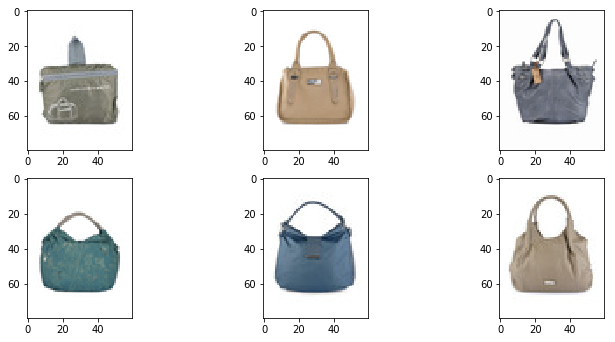

In [69]:
get_similar_item(0, feature_dict, lsh,5)

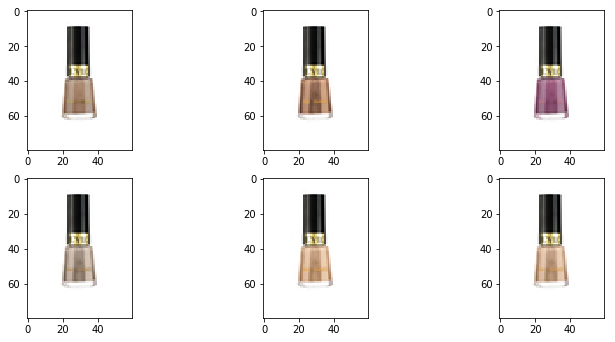

In [81]:
get_similar_item(15000, feature_dict, lsh,5)

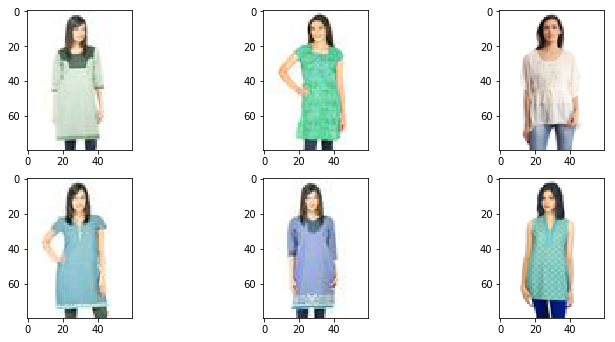

In [76]:
get_similar_item(30010, feature_dict, lsh,5)

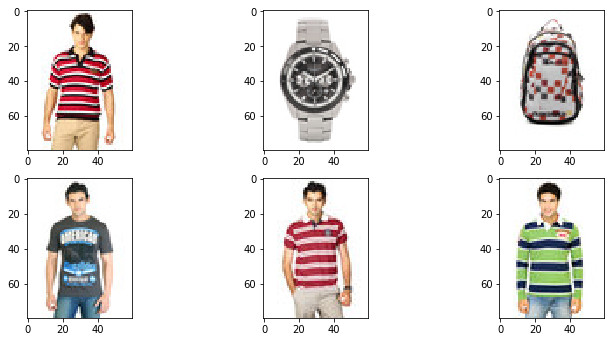

In [78]:
get_similar_item(40000, feature_dict, lsh,5)

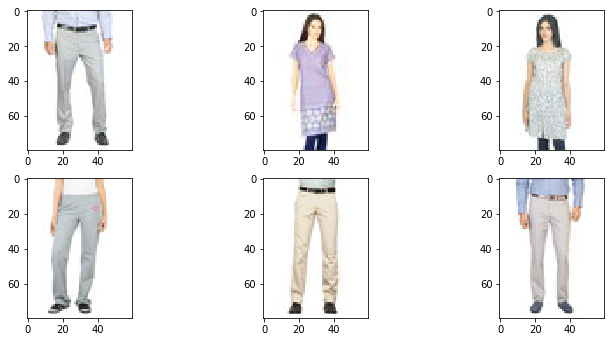

In [79]:
get_similar_item(5000, feature_dict, lsh,5)

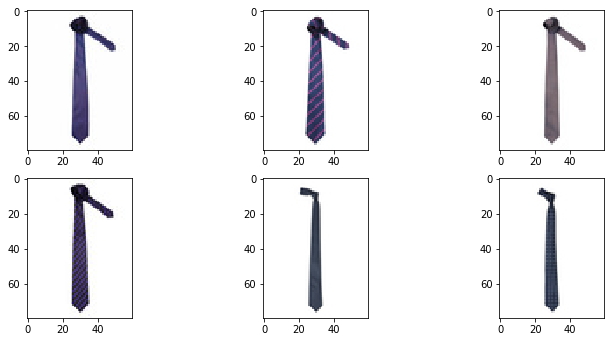

In [80]:
get_similar_item(25000, feature_dict, lsh,5)